<a href="https://colab.research.google.com/github/Calcifer777/learn-deep-learning/blob/main/generative-models/samples/WGAN_PL_f.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [259]:
%%bash

pip install -q torchinfo

In [529]:
from typing import List

from IPython.display import clear_output
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
from tqdm import tqdm

import torch
from torch import nn, Tensor
from torch.nn.functional import mse_loss
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms.v2.functional as F
from torchvision.utils import make_grid
from torchvision.transforms import (
    Compose,
    PILToTensor,
)
from torchinfo import summary

In [530]:
torch.manual_seed(42)
np.random.seed(42)

In [531]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

## Parameters

In [532]:
EPOCHS = 5
BATCH_SIZE = 64
LATENT_DIM = 100
BASE_DIM_GEN = 7
BASE_GEN_CH = 256
CRITIC_TO_GEN_UPDATES = 3
GP_WEIGHT = 10.0
PATH_SAMPLES = Path("./samples/")

LR_G = 1e-4
LR_C = 1e-4

In [533]:
PATH_SAMPLES.mkdir(exist_ok=True)

## Data

In [316]:
def transform(img):
    img = F.pil_to_tensor(img)
    img = (img - 127.5) / 255.0
    return img

In [322]:
ds_train = datasets.FashionMNIST(
    "./data/fashion-mnist/",
    download=True,
    train=True,
    transform=transform,
)

torch.Size([1, 28, 28])

In [318]:
dl_train = DataLoader(
    dataset=ds_train,
    batch_size=BATCH_SIZE,
)

In [323]:
sample_batch = next(iter(dl_train))
sample_batch[0].shape

torch.Size([8, 1, 28, 28])

## Models

In [389]:
class Critic(nn.Module):

    def __init__(self, *args, **kwargs):
        super(Critic, self).__init__(*args, **kwargs)
        self.net = nn.Sequential(
            self.conv_block(1, 64, batch_norm=False, activation=True),
            self.conv_block(64, 128, batch_norm=True, activation=True),
            nn.Conv2d(128, 1, kernel_size=(5, 5)),
            nn.Flatten(),
        )

    @staticmethod
    def conv_block(in_ch: int, out_ch: int, batch_norm: bool, activation: bool, kernel_size=4) -> Tensor:
        layers = [
            nn.Conv2d(in_ch, out_ch, kernel_size=4, stride=2, padding="valid"),
        ]
        if batch_norm:
            layers.append(nn.BatchNorm2d(out_ch))
        if activation:
            layers.append(nn.LeakyReLU(0.2))
            layers.append(nn.Dropout(0.2))
        return nn.Sequential(*layers)


    def forward(self, x: Tensor):
        x = self.net(x)
        return x

In [391]:
x = torch.rand((2, 1, 28, 28))
summary(Critic(), input_data=(x))

Layer (type:depth-idx)                   Output Shape              Param #
Critic                                   [2, 1]                    --
├─Sequential: 1-1                        [2, 1]                    --
│    └─Sequential: 2-1                   [2, 64, 13, 13]           --
│    │    └─Conv2d: 3-1                  [2, 64, 13, 13]           1,088
│    │    └─LeakyReLU: 3-2               [2, 64, 13, 13]           --
│    │    └─Dropout: 3-3                 [2, 64, 13, 13]           --
│    └─Sequential: 2-2                   [2, 128, 5, 5]            --
│    │    └─Conv2d: 3-4                  [2, 128, 5, 5]            131,200
│    │    └─BatchNorm2d: 3-5             [2, 128, 5, 5]            256
│    │    └─LeakyReLU: 3-6               [2, 128, 5, 5]            --
│    │    └─Dropout: 3-7                 [2, 128, 5, 5]            --
│    └─Conv2d: 2-3                       [2, 1, 1, 1]              3,201
│    └─Flatten: 2-4                      [2, 1]                    --
Tot

In [378]:
class Generator(nn.Module):
    def __init__(self, *args, **kwargs):
        super(Generator, self).__init__(*args, **kwargs)
        self.net = nn.Sequential(
            nn.Linear(LATENT_DIM, BASE_DIM_GEN * BASE_DIM_GEN * BASE_GEN_CH),
            nn.ReLU(0.2),
            nn.Unflatten(-1, (BASE_GEN_CH, BASE_DIM_GEN, BASE_DIM_GEN)),
            self.conv_block(BASE_GEN_CH, BASE_GEN_CH // 2, True, True),
            self.conv_block(BASE_GEN_CH // 2, 1, False, False),
            nn.Tanh(),
        )

    @staticmethod
    def conv_block(
        in_ch: int,
        out_ch: int,
        batch_norm: bool,
        activation: bool,
    ):
        # Base
        layers = [
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding="same"),
            nn.Upsample(scale_factor=2, mode='nearest'),
        ]
        if batch_norm:
            layers.append(nn.BatchNorm2d(out_ch))
        if activation:
            layers.append(nn.ReLU())
        return nn.Sequential(*layers)

    def forward(self, x: Tensor):
        return self.net(x)

In [379]:
z = torch.rand((2, 100))
summary(Generator(), input_data=z)

Layer (type:depth-idx)                   Output Shape              Param #
Generator                                [2, 1, 28, 28]            --
├─Sequential: 1-1                        [2, 1, 28, 28]            --
│    └─Linear: 2-1                       [2, 12544]                1,266,944
│    └─ReLU: 2-2                         [2, 12544]                --
│    └─Unflatten: 2-3                    [2, 256, 7, 7]            --
│    └─Sequential: 2-4                   [2, 128, 14, 14]          --
│    │    └─Conv2d: 3-1                  [2, 128, 7, 7]            295,040
│    │    └─Upsample: 3-2                [2, 128, 14, 14]          --
│    │    └─BatchNorm2d: 3-3             [2, 128, 14, 14]          256
│    │    └─ReLU: 3-4                    [2, 128, 14, 14]          --
│    └─Sequential: 2-5                   [2, 1, 28, 28]            --
│    │    └─Conv2d: 3-5                  [2, 1, 14, 14]            1,153
│    │    └─Upsample: 3-6                [2, 1, 28, 28]            --

## Train

In [428]:
generator = Generator().to(device)
critic = Critic().to(device)

opt_g = torch.optim.Adam(generator.parameters(), LR_G)
opt_c = torch.optim.Adam(critic.parameters(), LR_C)

In [429]:
def gradient_penalty(batch: Tensor, img_gen: Tensor) -> Tensor:
    interp_w = torch.rand((BATCH_SIZE, 1, 1, 1)).to(device)
    interp = interp_w * batch + (1-interp_w) * img_gen
    scores = critic(interp)
    norm = scores.norm(2, dim=-1)
    gp = mse_loss(norm, torch.ones_like(norm))
    return gp

In [430]:
def train_step_c(batch):
    opt_c.zero_grad()
    z = torch.rand((batch.shape[0], LATENT_DIM)).to(device)
    img_gen = generator(z).detach()
    score_real = critic(batch)
    score_gen = critic(img_gen)
    loss_w = score_gen.mean() - score_real.mean()
    loss_gp = gradient_penalty(batch, img_gen)
    loss = loss_w + GP_WEIGHT * loss_gp
    loss.backward()
    opt_c.step()
    return dict(
        loss_d=loss.item(),
        loss_d_w=loss_w.item(),
        loss_d_gp=loss_gp.item(),
    )

In [433]:
def train_step_g(batch):
    opt_g.zero_grad()
    z = torch.rand((batch.shape[0], LATENT_DIM))
    img_gen = generator(z)
    score = critic(img_gen)
    loss = - score.mean()
    loss.backward()
    opt_g.step()
    return dict(
        loss_g=loss.item(),
    )

In [512]:
%matplotlib inline

def live_plot(metrics: List[dict], title=''):
    df = pd.DataFrame.from_records(metrics)
    data_dict = df.to_dict(orient="list")
    #
    clear_output(wait=True)
    # plt.figure(figsize=(4, 16))
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    for ax, (k, v) in zip(axes.flatten(), data_dict.items()):
        ax.plot(v)
        ax.set_title(k)
    plt.grid(False)
    plt.show();

In [ ]:
@torch.inference_mode()
def generate_samples(fname):
    generator.eval()
    z = torch.rand((9, 100))
    x = generator(z)
    grid = make_grid(x, nrow=3)
    img = F.to_pil_image(grid)
    img.save(PATH_SAMPLES / (fname + "+png"))

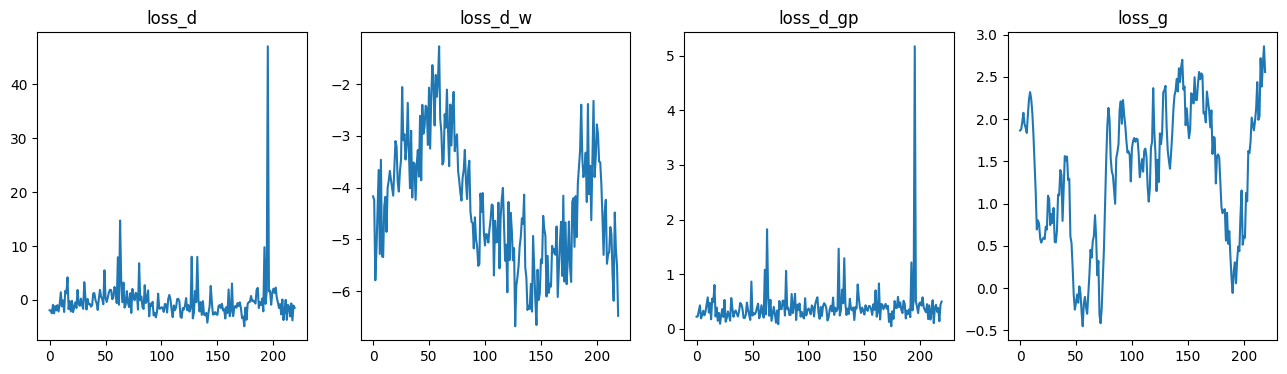

(227/7500) loss_d: -5.106 - loss_d_w: -7.113 - loss_d_gp: 0.201 - loss_g: 2.807:   3%|▎         | 227/7500 [00:48<25:57,  4.67it/s]


KeyboardInterrupt: 

In [513]:
history = []

pbar = tqdm(enumerate(dl_train, start=1), total=len(dl_train))
epoch_id = 0
for i, (batch, _) in pbar:
    generator.train()
    critic.train()
    batch = batch.to(device)
    for j in range(CRITIC_TO_GEN_UPDATES):
        loss_d = train_step_c(batch)
    loss_g = train_step_g(batch)
    metrics = {**loss_d, **loss_g}
    history.append(metrics)
    msg = (
        f"({i}/{len(dl_train)}) " +
        " - ".join(f"{m}: {v:.3f}" for m, v in metrics.items())
    )
    pbar.set_description(msg)
    if i % 20 == 0:
        live_plot(history)
        generate_samples(f"e{epoch_id:03d}_{i:04d}")